In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
print(torch.cuda.is_available(), torch.cuda.get_device_name(0), torch.backends.cudnn.is_available())
from torchvision import datasets
from torch.utils.data import TensorDataset, DataLoader
from torch import nn

True GeForce GTX 1650 with Max-Q Design True


In [2]:
train = datasets.MNIST(root=".", train=True, download=True)
test = datasets.MNIST(root=".", train=False, download=True)
print(len(train), np.array(train[0][0]).shape, train[0][1], len(test)) # (PIL,int) for each data

60000 (28, 28) 5 10000


C:\Users\James\miniconda3\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


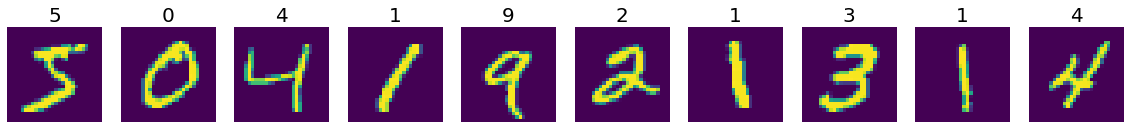

In [15]:
xTrain, yTrain = np.zeros((len(train),784)), np.zeros(len(train), dtype=np.int)
for i in range(len(train)):
    xTrain[i] = np.array(train[i][0]).reshape(784)/255.
    yTrain[i] = train[i][1]
xTest, yTest = np.zeros((len(test),784)), np.zeros(len(test), dtype=np.int)
for i in range(len(test)):
    xTest[i] = np.array(test[i][0]).reshape(784)/255.
    yTest[i] = test[i][1]

plt.figure(figsize=(20,5))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(xTrain[i].reshape(28,28))
    plt.title(train[i][1], fontsize=20)
    plt.axis("off")
plt.show()

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
trainDataset = TensorDataset(torch.Tensor(xTrain).to(device), \
    torch.Tensor(yTrain).type(torch.long).to(device))
testDataset  = TensorDataset(torch.Tensor(xTest).to(device), \
    torch.Tensor(yTest).type(torch.long).to(device))

batch_size = 64
trainDataLoader = DataLoader(trainDataset, batch_size=batch_size, shuffle=True)
testDataLoader  = DataLoader(testDataset, batch_size=batch_size, shuffle=True)

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        #self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )
    def forward(self, x):
        #x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)


In [6]:
learning_rate = 1e-3
epochs = 10
loss_fn = nn.CrossEntropyLoss() # auto cross-entropy
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()   # reset gradient value, otherwise keep adding up
        loss.backward()         # back propagation 
        optimizer.step()        # update all the model parameters
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)  # loss:tensor; loss.item():value
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [7]:
import time
start = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(trainDataLoader, model, loss_fn, optimizer)
    test_loop(testDataLoader, model, loss_fn)
print("Done!")
print(time.time()-start)

Epoch 1
-------------------------------
loss: 2.298216  [    0/60000]
loss: 2.299073  [ 6400/60000]
loss: 2.299296  [12800/60000]
loss: 2.293498  [19200/60000]
loss: 2.289381  [25600/60000]
loss: 2.289098  [32000/60000]
loss: 2.281966  [38400/60000]
loss: 2.279065  [44800/60000]
loss: 2.274619  [51200/60000]
loss: 2.263486  [57600/60000]
Test Error: 
 Accuracy: 45.7%, Avg loss: 0.035632 

Epoch 2
-------------------------------
loss: 2.268719  [    0/60000]
loss: 2.271034  [ 6400/60000]
loss: 2.271018  [12800/60000]
loss: 2.248596  [19200/60000]
loss: 2.251954  [25600/60000]
loss: 2.257789  [32000/60000]
loss: 2.236063  [38400/60000]
loss: 2.249322  [44800/60000]
loss: 2.230089  [51200/60000]
loss: 2.214587  [57600/60000]
Test Error: 
 Accuracy: 56.6%, Avg loss: 0.034897 

Epoch 3
-------------------------------
loss: 2.210853  [    0/60000]
loss: 2.237665  [ 6400/60000]
loss: 2.210038  [12800/60000]
loss: 2.222396  [19200/60000]
loss: 2.196933  [25600/60000]
loss: 2.172534  [32000/600

In [ ]:
"GPU time:10, CPU time:50, 5 times"

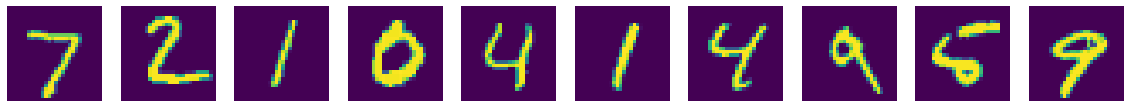

TRUE [7 2 1 0 4 1 4 9 5 9]
PRED [7 2 1 0 4 1 4 4 6 7]


In [17]:
model.eval() # (+no_grad) turn off gradient while inference # model.train() turn on gradient
with torch.no_grad():
    pred = model( torch.Tensor(xTest).to(device) )

plt.figure(figsize=(20,5))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(xTest[i].reshape(28,28))
    plt.axis("off")
plt.show()
print( "TRUE", yTest[:10] )
print( "PRED", pred[:10].argmax(dim=1).to("cpu").numpy() )

In [20]:
torch.save(model, "mnist.pth")

In [21]:
model = torch.load("mnist.pth")
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)


In [ ]:
from torchvision.models.detection import 